In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy


import os
import PIL
import math
import json
import pickle
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(38)

In [ ]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

num_epochs = 200
cache_train_num_epochs = 50
batch_size = 4
learning_rate = 0.001

In [ ]:
train_transform = transforms.Compose([
  transforms.Pad(4),
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32),
  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
  transforms.ToTensor()])

test_aug_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.ToTensor()])

test_transform = transforms.Compose([
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.ToTensor()])

train_dataset     = torchvision.datasets.CIFAR10(root='./data/' ,train=True,  transform=train_transform,  download=True)
test_dataset      = torchvision.datasets.CIFAR10(root='./data/' ,train=False, transform=test_transform)
test_aug_dataset  = torchvision.datasets.CIFAR10(root='./data/' ,train=False, transform=test_aug_transform)

train_loader     = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)
test_loader      = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, pin_memory=True, shuffle=False, drop_last=True )
test_aug_loader  = torch.utils.data.DataLoader(dataset=test_aug_dataset,  batch_size=batch_size, pin_memory=True, shuffle=False, drop_last=True )


100%|██████████| 170498071/170498071 [00:03<00:00, 42970482.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/


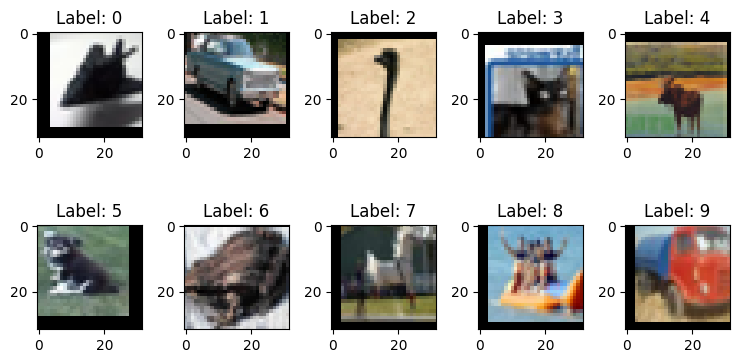

In [ ]:
def plot_set_images(n_row, n_col, images, labels, label_text="Label: "):
  num=len(images)
  num_row=n_row
  num_col=n_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
      ax.set_title('{}{}'.format(label_text, labels[i]))
  plt.tight_layout()
  plt.show()

# labels =
images_set = []
labels_set = []
j=0
for i in range(10):
  while i != train_dataset[j][1]:
    j += 1
  images_set.append(train_dataset[j][0])
  labels_set.append(train_dataset[j][1])


plot_set_images(2, 5, images_set, labels_set, "Label: ")

In [ ]:
def pgd_linf_end2end(model, X, labels, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), labels)
        loss.backward()
        with torch.no_grad():
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.data = torch.clamp(X + delta.data, min=0, max=1) - X
        delta.grad.zero_()
    return delta.detach()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install torchsummary
from torchsummary import summary
global intermediate_features
global layer_idx
global caches_training

caches_training = False

intermediate_features = {"o1":0, "o2":0, "o3":0, "o4":0, "o5":0, "o6":0, "o7":0, "o8":0}
layer_idx = 0



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        op1 = out
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        op2 = out

        if self.is_last:
            return out, preact

        else:
          global cach_training
          global layer_idx

          if caches_training is True and layer_idx < 8:
            # print("cach_training is True")
            layer_idx += 1
            intermediate_features["o"+str(layer_idx)] = op1
            layer_idx += 1
            intermediate_features["o"+str(layer_idx)] = op2
            # print()
            # print("layer idx is : " + str(layer_idx))
            # print()
            with open('features.pkl', 'wb') as fp:
              pickle.dump(intermediate_features, fp)

          return out




class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False, c_train=False):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.c_train=c_train


        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=512, out_features=10, bias=True)



        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves
        # like an identity. This improves the model by 0.2~0.3% according to:
        # https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)







    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)




    def forward(self, x):
        out1 = F.relu(self.bn1(self.conv1(x)))
        out2 = self.layer1(out1)
        out3 = self.layer2(out2)
        out4 = self.layer3(out3)
        out5 = self.layer4(out4)
        out6 = self.avgpool(out5)
        out6 = self.flatten(out6)
        out7 = self.fc(out6)
        out = torch.flatten(out7, 1)
        # print(out.size())

        return out






def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)


# def resnet34(**kwargs):
#     return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)




input_data = torch.randn(4, 3, 32, 32)  # Example input size (batch_size, channels, height, width)
# out = custom_resnet18(input_data.to(device))

# custom_resnet18.cache_train(2, train_loader, 8/255, 0.01, 20)
custom_resnet18 = resnet18().to(device)
x = custom_resnet18.forward(input_data.to(device))

# custom_resnet18._modules
# summary(custom_resnet18 , (3, 32, 32))


In [ ]:
class Predictor(nn.Module):
    def __init__(self, in_ch, h1_ch, h2_ch, lin_ch, lin_mult, out_ch=10):
        super(Predictor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=h1_ch, kernel_size=(5, 5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=h1_ch, out_channels=h2_ch, kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = nn.Linear(in_features=h2_ch*lin_mult*lin_mult, out_features=lin_ch)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=lin_ch, out_features=out_ch)
        self.logSoftmax = nn.LogSoftmax(dim=1)


    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        # print(x.size())
        x = self.maxpool1(x)
        # print(x.size())
        x = self.conv2(x)
        x = self.relu2(x)
        # print(x.size())
        x = self.maxpool2(x)
        # print(x.size())
        x = torch.flatten(x, 1)
        # print(x.size())
        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        output= self.logSoftmax(x)
          # = torch.flatten(x, 1)

        return output

p = Predictor(128,  256, 512, 128, 1, 10).to(device)
summary(p, (128, 16, 16))


class Selector(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 2)
        # self.act1 = F.softmax()


    def forward(self, x):
        x = F.softmax(self.fc1(x))

        return x



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 12, 12]         819,456
              ReLU-2          [-1, 256, 12, 12]               0
         MaxPool2d-3            [-1, 256, 6, 6]               0
            Conv2d-4            [-1, 512, 2, 2]       3,277,312
              ReLU-5            [-1, 512, 2, 2]               0
         MaxPool2d-6            [-1, 512, 1, 1]               0
            Linear-7                  [-1, 128]          65,664
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
       LogSoftmax-10                   [-1, 10]               0
Total params: 4,163,722
Trainable params: 4,163,722
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/backward pass size (MB): 0.67
Params size (MB): 15.88
Estima

In [ ]:
predictors = []
selectors = []


predictor1 = Predictor(64, 128, 256, 512, 5, 10)
predictor2 = Predictor(64, 128, 256, 512, 5, 10)
predictor3 = Predictor(64, 128, 256, 512, 5, 10)
predictor4=  Predictor(64, 128, 256, 512, 5, 10)
predictor5 = Predictor(128,  256, 512, 128, 1, 10)
predictor6 = Predictor(128,  256, 512, 128, 1, 10)
predictor7 = Predictor(128,  256, 512, 128, 1, 10)
predictor8 = Predictor(128,  256, 512, 128, 1, 10)

selector1 = Selector()
selector2 = Selector()
selector3 = Selector()
selector4 = Selector()
selector5 = Selector()
selector6 = Selector()
selector7 = Selector()
selector8 = Selector()


predictors.append(predictor1)
predictors.append(predictor2)
predictors.append(predictor3)
predictors.append(predictor4)
predictors.append(predictor5)
predictors.append(predictor6)
predictors.append(predictor7)
predictors.append(predictor8)




selectors.append(selector1)
selectors.append(selector2)
selectors.append(selector3)
selectors.append(selector4)
selectors.append(selector5)
selectors.append(selector6)
selectors.append(selector7)
selectors.append(selector8)



In [ ]:
from torch.autograd import Variable

def caches_train(model, predictors, selectors, cache_train_num_epochs, train_loader, eps_AT, alpha, iter_AT, train_type='st'):
        global caches_training
        global layer_idx

        caches_training = True
        p_criterions = []
        p_optimizers = []
        p_losses = []
        p_scheds = []

        s_criterions = []
        s_optimizers = []
        s_losses = []

        for i in range(len(predictors)):
          p_losses.append(torch.tensor(0., requires_grad=True))
          s_losses.append(torch.tensor(0., requires_grad=True))
        # print(losses)
        for predictor, selector in zip(predictors, selectors):
          predictor.to(device)
          criterion = nn.CrossEntropyLoss()
          optimizer = torch.optim.Adam(predictor.parameters(), lr=learning_rate)
          p_criterions.append(criterion)
          p_optimizers.append(optimizer)
          p_scheds.append(torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=cache_train_num_epochs, steps_per_epoch=len(train_loader)))

          selector.to(device)
          criterion_ = nn.CrossEntropyLoss()
          optimizer_ = torch.optim.Adam(predictor.parameters(), lr=learning_rate)
          s_criterions.append(criterion_)
          s_optimizers.append(optimizer_)



        for epoch in range(cache_train_num_epochs):
          for i, (image, label) in enumerate(train_loader):
              caches_training = True
              # print(i, epoch)
              images = image.to(device)
              labels = label.to(device)
              # print("labels : " + str(labels))
              # print("the input image sizes' : " + str(images.size()))
              Z_x0 = model(images)
              # print("the model's output (Z_x0) size : " + str(Z_x0.size()))
              # print("backbone outputs are : " + str(Z_x0.argmax(dim=1)))
              with open('features.pkl', 'rb') as fp:
                features = pickle.load(fp)
                # print("features keys : " + str(features.keys()))
                # print("features[o1] : " + str(features["o1"][0]))


              for idx in range(len(predictors)):
                # print("predictor " + str(idx+1))
                cache_input = features["o"+str(idx+1)].to(device)
                print(cache_input.size())
                p_outputs =  predictors[idx](cache_input).to(device)
                # print("predictor outputs : " + str(p_outputs.argmax(dim=1)))
                # print("cache input size " + str(cache_input.size()))
                # print("cache output size " + str(outputs.size()))
                p_losses[idx] = torch.tensor(p_criterions[idx](p_outputs, Z_x0).to(device), requires_grad=True)
                # print(loss)

                # Backward and optimize
                p_optimizers[idx].zero_grad()
                p_losses[idx].backward()
                p_optimizers[idx].step()
                p_scheds[idx].step()



                binary_comparison = torch.tensor([1 if p_outputs.argmax(dim=1)[i]==Z_x0.argmax(dim=1)[i] else 0 for i in range(len(Z_x0.argmax(dim=1)))])
                # print("binry : " + str(binary_comparison))
                s_outputs = selectors[idx](p_outputs).to(device)
                # print("selector outputs size : "+ str(s_outputs.size()[0]))
                s_losses[idx] = torch.tensor(s_criterions[idx](s_outputs, binary_comparison.to(device)).to(device), requires_grad=True)

                s_optimizers[idx].zero_grad()
                s_losses[idx].backward()
                s_optimizers[idx].step()

              features.clear()
              layer_idx = 0
              os.remove("features.pkl")
              # print("ba-bye!")
              if i==1:
                break
        return predictors, selectors
caches_train(custom_resnet18, predictors, selectors, 2, train_loader, 0.01, 1/255, 5, train_type='st')

torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])


<ipython-input-10-551d0650254d>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_losses[idx] = torch.tensor(p_criterions[idx](p_outputs, Z_x0).to(device), requires_grad=True)
<ipython-input-8-b6c1bc4e8b2d>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc1(x))
<ipython-input-10-551d0650254d>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_losses[idx] = torch.tensor(s_criterions[idx](s_outputs, binary_comparison.to(device)).to(device), requires_grad=True)


torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 64, 32, 32])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])
torch.Size([4, 128, 16, 16])


([Predictor(
    (conv1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=6400, out_features=512, bias=True)
    (relu3): ReLU()
    (fc2): Linear(in_features=512, out_features=10, bias=True)
    (logSoftmax): LogSoftmax(dim=1)
  ),
  Predictor(
    (conv1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=6400, out_fea

In [ ]:
def train(model, train_loader, criterion, optimizer, sched, eps_AT, alpha, iter_AT, training_type='st'):
  model.train()
  global  caches_training

  caches_training = False

  accuracies_st = []
  accuracies_at = []
  if training_type == 'st':
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs =  model(images).to(device)
            loss = criterion(outputs, labels).to(device)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            sched.step()



        if epoch%10==0:
          # print('epoch : ' + str(epoch) +' -->  loss_Train = ' + str(np.array(losses).mean()))
          acc_st = test(model,test_loader, eps_AT, alpha, iter_AT, test_type='st')
          acc_at = test(model,test_loader, eps_AT, alpha, iter_AT, test_type='at')
          accuracies_st.append(acc_st)
          accuracies_at.append(acc_at)
          model.train()



  elif training_type == 'at':
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            delta = pgd_linf_end2end(model, images, labels, eps_AT, alpha, iter_AT)
            images_adv = (images + delta).to(device)
            Z_x0 = model(images_adv).to(device)
            loss = criterion(Z_x0, labels).to(device)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            sched.step()

        # print('epoch : ' + str(epoch) +' -->  loss_Train = ' + str(np.array(losses).mean()))
        if epoch%10==0:
          # print('epoch : ' + str(epoch) +' -->  loss_Train = ' + str(np.array(losses).mean()))
          acc_st = test(model,test_loader, eps_AT, alpha, iter_AT, test_type='st')
          acc_at = test(model,test_loader, eps_AT, alpha, iter_AT, test_type='at')
          accuracies_st.append(acc_st)
          accuracies_at.append(acc_at)
          model.train()

  return model, accuracies_st, accuracies_at


In [ ]:
def test(model, predictors, selectors, test_loader, eps_t2, alpha, iter_t2, test_type='st'):
  model.eval()

  global  caches_training
  caches_training = True

  total_acc_test = 0
  p_inferences = [[0, 0, 0] for _ in range(len(predictors))]
  s_inferences = [[0, 0, 0, 0] for _ in range(len(selectors))]
  print("p_inferences  : " + str(p_inferences))
  print("s_inferences  : " + str(s_inferences))


  if test_type=='st':
    for i, (X, labels) in enumerate(test_loader):
          print(" i : " + str(i))
          X = X.to(device)
          labels = labels.to(device)
          print("labels are : " + str(labels))
          Z =  model(X).to(device)
          remainders = [i for i in range(X.size()[0])]
          print("remaiders are : " + str(remainders))
          with open('features.pkl', 'rb') as fp:
                features = pickle.load(fp)


          for idx in range(len(selectors)):
              cache_input = features["o"+str(idx+1)][remainders].to(device)
              print("cache input size for predictor " + str(idx+1)  + " is : " + str(len(cache_input)))
              # print("len cache_input[0] : " + str(cache_input[0].size()))
              if cache_input.size()==0:
                print("Tamam Arkadeshim!")
                break
              # اندازه های حلقه ها در ادامه باید تغییر کند و متناسب با کش اینپوت هر کش باشد
              p_outputs =  predictors[idx](cache_input).to(device)
              print("p_outputs : " + str(p_outputs.argmax(dim=1)))
              print("z_outputs : " + str(Z.argmax(dim=1)) )
              backbone_predictor_comparison = torch.tensor([1 if p_outputs.argmax(dim=1)[k]==Z.argmax(dim=1)[remainders[k]] else 0 for k in range(len(remainders))])
              labels_predictor_comparison = torch.tensor([1 if (p_outputs.argmax(dim=1)[k]!=Z.argmax(dim=1)[remainders[k]] and p_outputs.argmax(dim=1)[k] == labels[remainders[k]]) else 0 for k in range(len(remainders))])
              print("backbone_predictor_comparison : " + str(backbone_predictor_comparison))
              print("label_predictor_comparison : " + str(labels_predictor_comparison))

              p_inferences[idx][0] += torch.sum(labels_predictor_comparison)
              p_inferences[idx][1] += torch.sum(backbone_predictor_comparison)
              p_inferences[idx][2] += p_outputs.size()[0]
              # print("ratio backbone_predictor_comparison : " + str(p_inferences[idx][1]/p_inferences[idx][2]))
              # print("ratio label_predictor_comparison : " + str(p_inferences[idx][0]/p_inferences[idx][2]))


              s_outputs = selectors[idx](p_outputs).to(device)

              s_argmax = torch.tensor([1 if s_outputs[k][1]>=0.7 else 0 for k in range(s_outputs.size()[0])])
              # print("s_outputs : " + str(s_outputs))
              print("s_argmax : " + str(s_argmax))
              s_success = torch.tensor([1 if (backbone_predictor_comparison[k]==1 and s_argmax[k]==1) else 0 for k in range(s_argmax.size()[0])])
              s_super_success = torch.tensor([1 if (labels_predictor_comparison[k]==1 and s_argmax[k]==1) else 0 for k in range(s_argmax.size()[0])])
              s_fail = torch.tensor([1 if (backbone_predictor_comparison[k]==1 and s_argmax[k]==0) else 0 for k in range(s_argmax.size()[0])])
              s_inferences[idx][0] += torch.sum(s_super_success).item()
              s_inferences[idx][1] += torch.sum(s_success).item()
              s_inferences[idx][2] += torch.sum(s_fail).item()
              s_inferences[idx][3] += s_outputs.size()[0]
              print("ratio super success : " + str(s_inferences[idx][0]/s_inferences[idx][3]))
              print("ratio success : " + str(s_inferences[idx][1]/s_inferences[idx][3]))
              print("ratio fail : " + str(s_inferences[idx][2]/s_inferences[idx][3]))

              tmp = []
              for k in range(s_argmax.size()[0]):
                if s_argmax[k]==0 :
                 tmp.append(k)

              remainders = tmp
              if len(remainders)==0:
                break
              print("remainders are :" + str(remainders))







          features.clear()
          layer_idx = 0
          # os.remove("features.pkl")

          total_acc_test += (Z.max(dim=1)[1] == labels).sum().item()
          if i == 1:
            break
    # print('Acc_Test =', total_acc_test / len(test_loader.dataset),sep="\t")
    return total_acc_test / len(test_loader.dataset)



  elif test_type=='at':
    for i, (X, labels) in enumerate(test_loader):
          X = X.to(device)
          labels = labels.to(device)
          delta = pgd_linf_end2end(model, X, labels, eps_t2, alpha, iter_t2)
          X_adv = (X + delta)
          Z2 = model(X_adv)
          predicted2 = Z2.argmax(1)
          total_acc_test += (Z2.max(dim=1)[1] == labels).sum().item()

    # print('Acc_Test =', total_acc_test / len(test_loader.dataset),sep="\t")
    return total_acc_test/len(test_loader.dataset)

x = test(custom_resnet18, predictors, selectors, test_loader, 0.01, 2/255, 20, test_type='st')



p_inferences  : [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]
s_inferences  : [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
 i : 0
labels are : tensor([3, 8, 8, 0], device='cuda:0')
remaiders are : [0, 1, 2, 3]
cache input size for predictor 1 is : 4
p_outputs : tensor([7, 3, 3, 3], device='cuda:0')
z_outputs : tensor([7, 7, 7, 7], device='cuda:0')
backbone_predictor_comparison : tensor([1, 0, 0, 0])
label_predictor_comparison : tensor([0, 0, 0, 0])
s_argmax : tensor([0, 0, 0, 0])
ratio super success : 0.0
ratio success : 0.0
ratio fail : 0.25
remainders are :[0, 1, 2, 3]
cache input size for predictor 2 is : 4
p_outputs : tensor([9, 2, 2, 2], device='cuda:0')
z_outputs : tensor([7, 7, 7, 7], device='cuda:0')
backbone_predictor_comparison : tensor([0, 0, 0, 0])
label_predictor_comparison : tensor([0, 0, 0, 0])
s_argmax : tensor([0, 0, 0, 0])
ratio super success : 0.0
ratio succ

<ipython-input-8-b6c1bc4e8b2d>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc1(x))


In [ ]:
"""ToDo:
1-train 2 models with at and st but in both cases caches should be trained standardly
2-save models and caches for later
3-test them with augmented and clean test-dataset and/or cifar10-corrupted
4-implement the test with early exit scheme from caches
5-compare inference time, accuracy, caches hit rates, robustness, and ... for both models
6-try different epsilons = 2/255, 8/255, 16/255

In [ ]:
def plot_legend(accuracies):
  epochs = np.arange(0, num_epochs, 10)
  plt.plot(epochs, np.array(accuracies[0]), label ='standard trained')
  plt.plot(epochs, np.array(accuracies[1]), label ='adversarial trained (a=2/255)')
  plt.plot(epochs, np.array(accuracies[2]), label ='adversarial trained (a=8/255)')
  plt.legend()
  plt.show()

In [ ]:
models = []
trained_models = []
accuracies_st = []
accuracies_at = []

criterions = []
optimizers = []
scheds = []
#creating three models : 1st:resnet_st, 2nd:resnet_at_2_255, 3rd:resnet_at_8_255
for i in range(3):
  models.append(resnet18().to(device))
  criterions.append(nn.CrossEntropyLoss())
  optimizers.append(torch.optim.Adam(models[i].parameters(), lr=learning_rate, weight_decay=weight_decay))
  scheds.append(torch.optim.lr_scheduler.OneCycleLR(optimizers[i], max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader)))

for i in range(3):
  if i == 0:
    resnet_st, accuracy_st, accuracy_at = train(models[0], train_loader, criterions[0],optimizers[0], scheds[0], 8/255, 0.01, 5, test_type='st'):
    trained_models.append(resnet_st)
    accuracies_st.append(accuracy_st)
    accuracies_at.append(accuracy_at)
  elif i == 1:
    resnet_at_2_255, accuracy_st, accuracy_at = train(models[1], train_loader, criterions[1], optimizers[1], scheds[1], 2/255, 0.01, 5, test_type='at'):
    trained_models.append(resnet_at_2_255)
    accuracies_st.append(accuracy_st)
    accuracies_at.append(accuracy_at)
  elif i == 2:
    resnet_at_8_255, accuracy_st, accuracy_at = train(models[2], train_loader, criterions[2], optimizers[2], scheds[2], 8/255, 0.01, 5, test_type='at'):
    trained_models.append(resnet_at_8_255)
    accuracies_st.append(accuracy_st)
    accuracies_at.append(accuracy_at)







In [ ]:
plot_legend(accuracies_st)

In [ ]:
plot_legend(accuracies_at)

In [ ]:
predictors_st = []
predictors_at_2_255 = []
predictors_at_8_255 = []

selectors_st = []
selectors_at_2_255 = []
selectors_at_8_255 = []

for i in range(3):
  predictors = []
  selectors = []

  predictor1 = Predictor(64, 128, 256, 512, 5, 10)
  predictor2 = Predictor(64, 128, 256, 512, 5, 10)
  predictor3 = Predictor(64, 128, 256, 512, 5, 10)
  predictor4=  Predictor(64, 128, 256, 512, 5, 10)
  predictor5 = Predictor(128,  256, 512, 128, 1, 10)
  predictor6 = Predictor(128,  256, 512, 128, 1, 10)
  predictor7 = Predictor(128,  256, 512, 128, 1, 10)
  predictor8 = Predictor(128,  256, 512, 128, 1, 10)

  selector1 = Selector()
  selector2 = Selector()
  selector3 = Selector()
  selector4 = Selector()
  selector5 = Selector()
  selector6 = Selector()
  selector7 = Selector()
  selector8 = Selector()


  predictors.append(predictor1)
  predictors.append(predictor2)
  predictors.append(predictor3)
  predictors.append(predictor4)
  predictors.append(predictor5)
  predictors.append(predictor6)
  predictors.append(predictor7)
  predictors.append(predictor8)




  selectors.append(selector1)
  selectors.append(selector2)
  selectors.append(selector3)
  selectors.append(selector4)
  selectors.append(selector5)
  selectors.append(selector6)
  selectors.append(selector7)
  selectors.append(selector8)

  if i == 0:
   predictors_st = predictors.copy()
   selectors_st = selectors.copy()
   predictors.clear()
   selectors.clear()

   p_st, s_st = caches_train(trained_models[0], predictors_st, selectors_st, cache_train_num_epochs, train_loader, 8/255, 0.01, 5,, train_type='st'):


  elif i == 1:
    predictors_at_2_255 = predictors.copy()
    selectors_at_2_255 = selectors.copy()
    predictors.clear()
    selectors.clear()

    p_at_2_255, s_at_2_255 = caches_train(trained_models[1], predictors_at_2_255, selectors_at_2_255, cache_train_num_epochs, train_loader, 8/255, 0.01, 5,, train_type='st'):


  elif i == 2:
    predictors_at_8_255 = predictors.copy()
    selectors_at_8_255 = selectors.copy()
    predictors.clear()
    selectors.clear()
    p_at_8_255, s_at_8_255 = caches_train(trained_models[1], predictors_at_2_255, selectors_at_2_255, cache_train_num_epochs, train_loader, 8/255, 0.01, 5,, train_type='st'):




In [ ]:
!pip install torch_cka
from torch_cka import CKA

def representation_comparison(model1, model2, model1_name, model2_name, dataloader1, dataloader2):
  cka = CKA(model1, model2,
            model1_name=model1_name,   # good idea to provide names to avoid confusion
            model2_name=model2_name,
            device=device)

  cka.compare(dataloader1, dataloader2) # secondary dataloader is optional

  results = cka.export()  # returns a dict that contains model names, layer names

  return results

In [ ]:
def conf_matrix(results):
  fig, ax = plt.subplots()
  im = ax.imshow(results['CKA'], origin='lower', cmap='magma')
  ax.set_xlabel(f"Layers {results['model1_name']}", fontsize=15)
  ax.set_ylabel(f"Layers {results['model2_name']}", fontsize=15)

  plt.tight_layout()

In [ ]:
results1 = representation_comparison(models[0], models[1], "Resnet18_ST", "Resnet18_AT", test_loader, test_loader)
conf_matrix(results1)

In [ ]:
results2 = representation_comparison(models[0], models[0], "Resnet18_ST", "Resnet18_ST", test_loader, test_loader)
conf_matrix(results2)

In [ ]:
results3 = representation_comparison(models[1], models[1], "Resnet18_AT_2/255", "Resnet18_AT_2/255", test_loader, test_loader)
conf_matrix(results3)

In [ ]:
results4 = representation_comparison(models[2], models[2], "Resnet18_AT_8/255", "Resnet18_AT_8/255", test_loader, test_loader)
conf_matrix(results4)

In [ ]:
results5 = representation_comparison(models[1], models[2], "Resnet18_AT_2/255", "Resnet18_AT_8/255", test_loader, test_loader)
conf_matrix(results5)

In [ ]:
results6 = representation_comparison(models[0], models[2], "Resnet18_ST", "Resnet18_AT_8/255", test_loader, test_loader)
conf_matrix(results6)